# 18.065 Pset 1 Solutions

## Problem 1 (4+4+4+4+4 points)

Recall from class that multiplying an $m \times p$ by a $p \times n$ matrix costs $mnp$ scalar multiplications (and a similar number of additions) by the standard (practical) algorithms.

Matrix multiplication is **not commutative** ($AB \ne BA$ in general), but it **is associative**: $(AB)C=A(BC)$.   It turns out that where you put the parentheses (i.e. in *what order* you do the multiplications) can make a *huge* difference in computational cost.

**(a)** If $x \in \mathbb{R}^n$ and $A,B$ are $n \times n$ matrices, compare the scalar multiplication counts of $(AB)x$ vs. $A(Bx)$, i.e. if we do the multiplications in the order indicated by the parentheses.

**(b)** If $x, b\in \mathbb{R}^n$, **how many scalar multiplications** does the computation $$p = (I - (xx^T)/(x^T x)) b$$ take if we *do it in the order indicated by the parentheses*?  (Note that dividing by a scalar $\alpha$ is equivalent to multiplying by $\alpha^{-1}$ at the negligible cost of one scalar division.)

**(c)** Explain how to compute the *same* $p$ as in part (b) using as *few multiplications as possible*.  Outline the sequence of computational steps, and give the count of multiplications.

**(d)** $p^T x = $ what?

**(e)** Implement your algorithm from (c) in Julia, filling in the code below, and time it for $n=1000$ using the `@btime` macro from the [BenchmarkTools package](https://github.com/JuliaCI/BenchmarkTools.jl), along with the algorithm from part (b), following the outline below.  How does the ratio of the two times compare to your ratio of multiplication counts?

### Solution:

**(a)** $AB$ requires $n^3$ scalar multiplications ($n^2$ row×col dot products), and $Bx$ requires $n^2$ multiplications ($n$ dot products).  So, $(AB)x$ requires $\boxed{n^3 + n^2}$ multiplications, while $A(Bx)$ requires $\boxed{2n^2}$ multiplications (a *lot* fewer for large $n$!).

**(b)** $$p = (I - (xx^T)/(x^T x)) b$$, computed in this order, requires (1) $n$ multiplies for $x^T x$, (2) $n^2$ multiplies for $xx^T$, (3) $n^2$ multiplies to scale $xx^T$ by $(x^T x)^{-1}$ (+ 1 division), (4) no multiplies to subtract from $I$, and (5) $n^2$ multiplies to multiply by $b$.  Total: $\boxed{3n^2 + n}$ scalar multiplications.

**(c)** If we re-arrange it as $$p = b - x((x^T b)/(x^T x))$$, then it requires only $\boxed{3n+1}$ multiplications: $2n$ for the two dot products, 1 for the scalar division (counting it as a scalar multiplication by the inverse as instructed), and $n$ to scale $x$.

**(d)** By remembering your linear algebra, you might recognize $P = (xx^T)/(x^T x)$ as **orthogonal projection** onto the direction of $x$, and hence $I-P$ is projection **perpendicular** to $x$.  So, we must have $\boxed{p^T x = 0}$.  But we can also compute this explicitly:
$$
p^T x = x^T p = x^T \left[ b - x((x^T b)/(x^T x)) \right] = \\
x^T b - (x^T x)(x^T b)/(x^T x) = x^T b - x^T b = 0 \, .
$$

**(e)** See the following code.  On my laptop, my part (c) solution is about **3400× faster** than part (b), which is actually bigger than the ratio of $(3n^2 + n) / (3n+1) = n = 1000$ you might predict just by counting multiplications, but it is the right order of magnitude.

Of course, computers are *much* more complicated than simple arithmetic counts than capture, and you will almost never be able to predict performance ratios simply by arithmetic counts.   To get a sense of this complexity, it's interesting to plot $\frac{1}{n}\text{(time for b)}/\text{(time for c)}$ versus $n$.  Arithmetic counts would predict this ratio to be a constant, but in fact it is much more complicated. (You were *not* required to do this — I show it below only for interest.)

In [1]:
using LinearAlgebra, BenchmarkTools

# algorithm from part (b)
function part_b(x, b)
    return (I - (x*x')*(x'*x)^-1) * b
end

# algorithm from part (c)
function part_c(x, b)
    # CHANGE THIS:
    return b - x * ((x'*b)/(x'*x))
end

# test and benchmark on random vectors:
n = 1000
x, b = rand(n), rand(n)

# test it first — should give same answer up to roundoff error
if part_c(x, b) ≈ part_b(x, b)
    println("Hooray, part (c) and part (b) agree!")
else
    error("You made a mistake: part (c) and part (b) do not agree!")
end

# benchmark it:

println("\npart (b): ")
@btime part_b($x, $b);

println("\npart (c): ")
@btime part_c($x, $b);

Hooray, part (c) and part (b) agree!

part (b): 
  4.143 ms (7 allocations: 22.90 MiB)

part (c): 
  1.279 μs (2 allocations: 15.88 KiB)


In [2]:
4.413e-3 / 1.279e-6 # ratio of times

3450.351837372948

In [7]:
# for interest, let's plot (time for b) / (n*(time for c)) versus n,
# and see how different it is from a constant:

ns = round.(Int, 10 .^ range(1, 4, length=20)) # log-spaced points

t_bc = map(ns) do n
    @show n
    x, b = rand(n), rand(n)
    @belapsed(part_b($x, $b)), @belapsed(part_c($x, $b))
end

t_ratio = first.(t_bc) ./ (ns .* last.(t_bc))

n = 10
n = 14
n = 21
n = 30
n = 43
n = 62
n = 89
n = 127
n = 183
n = 264
n = 379
n = 546
n = 785
n = 1129
n = 1624
n = 2336
n = 3360
n = 4833
n = 6952
n = 10000


20-element Vector{Float64}:
 0.4198663315479747
 0.4024561123451314
 0.5016266576985883
 0.5217398342398343
 0.5499016471424656
 0.5297567217200534
 0.7579014598586505
 1.0874537900252532
 1.0783124610718169
 0.7767890148134123
 0.9204295359856696
 1.2168404617858037
 2.2617932818717397
 3.025106985400225
 3.060177735357155
 3.1275025975637285
 3.0167103840430975
 7.520125153516695
 8.25342810247817
 8.673908026056296

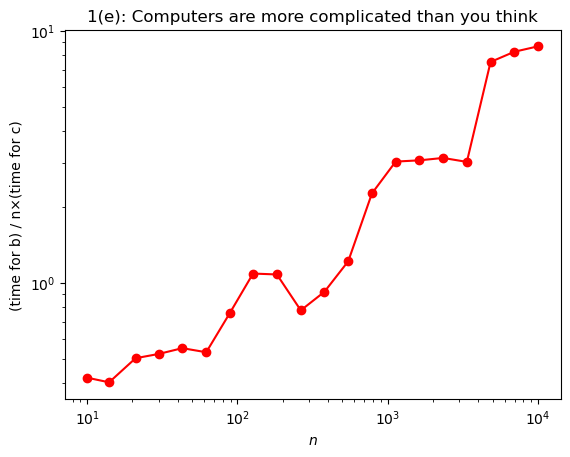

PyObject Text(24.000000000000007, 0.5, '(time for b) / n×(time for c)')

In [10]:
using PyPlot
loglog(ns, t_ratio, "ro-")
title("1(e): Computers are more complicated than you think")
xlabel(L"n")
ylabel("(time for b) / n×(time for c)")

The ratio (the speedup from part c) actually **grows with n**, mainly because part (b) also uses more memory ($\sim n^2$ rather than $\sim n$) and [using more memory is slower](https://en.wikipedia.org/wiki/Memory_hierarchy).

Interestingly, part (b) is actually *faster* than (c) for very small matrices, possibly because matrix–vector products are so heavily optimized in [linear-algebra software](https://www.openblas.net/).   We could get a bit faster in (c) by optimizing `b - x * ((x'*b)/(x'*x))` in order to [fuse the loops](https://julialang.org/blog/2017/01/moredots/), or maybe by calling an optimized [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) operation for [axpy](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.axpy!).

## Problem 2 (8+4 points)

**(a)** Describe the four fundamental subspaces of the **rank-1 matrix** $A = uv^T$ where $u \in \mathbb{R}^m$ and $n \in \mathbb{R}^n$.

**(b)** For any column vectors $u,v \in \mathbb{R}^3$, the matrix $uv^T$ is rank 1, except when \_\_\_\_\_\_\_\_, in which case $uv^T$ has rank \_\_\_\_.

### Solution

**(a)** Since the matrix is given to be "rank-1", we can assume $u, v \ne 0$ (see part b).  In that case, the four subspaces are:

1. Column space $C(uv^T) \subseteq \mathbb{R}^m$ is 1-dimensional and is **spanned by u**.
2. Row space $C(vu^T) \subseteq \mathbb{R}^n$ is 1-dimensional and is **spanned by v**.
3. Nullspace $N(uv^T)$ is $n-1$ dimensional and is **every vector orthogonal to v**.
3. Left nullspace $N(vu^T)$ is $m-1$ dimensional and is **every vector orthogonal to u**.

**(b)** $uv^T$ is always rank 1 exept when **u and/or v is 0**, in which case it has **rank 0**.

## Problem 3 (5+4+4+4 points)

**(a)** Pick the choices that makes this statement correct for arbitrary matrices A and B:  $C(AB)$ (*contains / is contained in*) the column space of (*A / B*).  Briefly justify your answer.

**(b)** Suppose that $A$ is a $1000\times 1000$ matrix of rank $< 10$.  Suppose we multiply it by 10 random vectors $x_1, x_2, \ldots, x_{10}$, e.g. generated by `randn(1000)`.  How could we use the results to get a $10\times 10$ matrix $C$ whose rank (almost certainly) matches $A$'s?

**(c)** Suppose we instead make $1000\times 10$ matrix $X$ whose columns are $x_1, x_2, \ldots, x_{10}$.  Give a formula for the *same* matrix $C$ in terms of matrix products involving $A$ and $X$.

**(d)** Fill in the code for $C$ below, and compare the biggest 10 singular values of $A$ (chosen to be rank ≈ 4 in this case) to the corresponding 10 singular values of $C$.  Does it match what you expect?

### Solution

**(a)** C(AB) **is contained in** the column space of **A**.   The reason is that any $y \in C(AB)$, we have $y = ABx = A(Bx)$, so $y \in C(A)$.   (The converse is not necessarily true, e.g. if $B = 0$.)

**(b and c)** I will answer these together.  The only reason for asking (c) separately was to make sure you know how to express your answer in matrix notation.

First, realize that $AX$ *almost certainly* (probability 1) has the **same rank as A**, i.e. we have a $1000 \times 10$ matrix with the same rank as A.
* Proof: Suppose $C(AX)$ were lower-dimensional than $C(A)$, in which case consider the orthogonal complement of $C(AX)$ in $C(A)$: there must be some direction $y\ne 0$ in $C(A) = N(A^T)^\perp$ perpendicular to everything in $C(AX)$, i.e. $y^TAX = 0$.  But that would require every one of our "random" vectors $x_k$ to be orthogonal to $A^T y$ (≠ 0 since $y \notin  N(A^T)$), which happens with probability 0.

Now, how can we reduce this to a $10\times 10$ matrix?  If we are to use only elementary matrix operations (no fair using something like an SVD that you don't personally know how to compute), this suggests multipling $AX$ on the left by some $10 \times 1000$ matrix.  But which one?  There are several valid choices:

1. You could use $X^T AX$.  (This could only reduce the rank if $X$ was $\perp$ to some portion of $C(A)$, which happens with probability 0.)
2. You could use $Y^T AX$, where $Y$ is another $1000 \times 10$ random matrix like `randn(1000,10)`.  (Again almost surely will have the same rank.)
3. You could use $(AX)^T (AX) = X^T A^T A X$.   In 18.06 and similar intro linear-algebra courses we prove that $B^T B$ has the same rank as $B$ for any $B$.  (Proof by showing that $N(B) = N(B^T B)$:  $Bx = 0 \implies B^TBx = 0$, and $B^T Bx = 0 \implies x^T B^T B x = 0 = \Vert Bx \Vert^2 \implies Bx = 0$.)

I think these are the easiest possibilities.

**(d)** Let's try all three possibilities from above in Julia:

In [11]:
using LinearAlgebra

# random 1000x1000 matrix of rank 4
A = randn(1000, 4) * randn(4, 1000)
@show svdvals(A)[1:10]

# possibility 1: XᵀAX
X = randn(1000, 10)
@show svdvals(X'*A*X)

# possibility 2: YᵀAX
Y = randn(1000, 10)
@show svdvals(Y'*A*X)

# possibility 3: (AX)ᵀAX
@show svdvals((A*X)'*A*X)

(svdvals(A))[1:10] = [1069.3195877770895, 1032.123298970407, 998.5420983487572, 963.6168764929388, 1.197027719541634e-12, 9.397013502391205e-13, 8.816489090342173e-13, 8.368786422681453e-13, 7.163119064816855e-13, 6.558305069443912e-13]
svdvals(X' * A * X) = [17355.334466001634, 10725.604519449384, 8360.035414898422, 2369.8158461371777, 7.68456896867752e-12, 5.9484402119558325e-12, 2.9567758084067988e-12, 2.0377094428213978e-12, 1.0361892803083682e-12, 1.7189758977956257e-13]
svdvals(Y' * A * X) = [11903.189430493283, 11182.390116386241, 6413.062698992587, 3644.0437181289303, 4.420883286604323e-12, 3.670046234886016e-12, 3.053253554336238e-12, 2.327401156370041e-12, 2.2006586809078315e-12, 1.4777079446259352e-12]
svdvals((A * X)' * A * X) = [1.8887124303351242e7, 1.2865209490083521e7, 7.204356096870981e6, 3.603491360462107e6, 4.0543542578357826e-9, 3.7280041982774055e-9, 2.130547526629226e-9, 1.2473174612561205e-9, 1.113501138973212e-9, 8.507451167986952e-12]


10-element Vector{Float64}:
 1.8887124303351242e7
 1.2865209490083521e7
 7.204356096870981e6
 3.603491360462107e6
 4.0543542578357826e-9
 3.7280041982774055e-9
 2.130547526629226e-9
 1.2473174612561205e-9
 1.113501138973212e-9
 8.507451167986952e-12

A has rank 4, so it should only have 4 nonzero singular values in theory.  In fact, *all* of its singular values are nonzero, but **only 4** of them (≈ 1069, 1032, 998, 963) are **non-negligible** — the remaining singular values are on the order of [machine precision 10⁻¹⁶](https://en.wikipedia.org/wiki/Machine_epsilon) times $\sigma_1 \approx 1000$, i.e. they are $\sim 10^{-12}$.  These are due to [roundoff errors](https://en.wikipedia.org/wiki/Round-off_error) in computer arithmetic.

For all 3 of our $10\times 10$ matrices, we indeed see the same thing: **4 non-negligible** singular values, and the rest are roundoff errors.  Indeed, 4 singular values are much *larger* than those of $A$, which is a consequence of our lack of normalization of $X$ and $Y$.  The biggest are the singular values of $(AX)^T AX = X^T A^T A X$, which shouldn't be surprising — this *squares* the singular values of $AX$.

## Problem 4 (4+5+5 points)

The famous Hadamard matrices are filled with ±1 and have orthogonal columns (orthonormal if we divide $H_n$ by $1/\sqrt{n}$).  The first few are:
\begin{align}
 H_1 &= \begin{pmatrix} 1 \end{pmatrix}, \\
  H_2 &= \begin{pmatrix}
    1 &  1 \\
    1 & -1
  \end{pmatrix}, \\
  H_4 &= \begin{pmatrix} H_2 & H_2 \\ H_2 & -H_2 \end{pmatrix} = \begin{pmatrix}
    1 &  1 &  1 &  1\\
    1 & -1 &  1 & -1\\
    1 &  1 & -1 & -1\\
    1 & -1 & -1 &  1
  \end{pmatrix} \, .
\end{align}
Notice that (for power-of-2 sizes), they are built up "recursively" out of smaller Hadamard matrices.  Multiplying a vector by a Hadamard matrix requires no multiplications at all, only additions/subtractions.

**(a)** If you multiply $H_4 x$ for some $x \in \mathbb{R}^4$ by the normal "rows-times-columns" method (*without* exploiting any special patterns), exactly how many scalar additions/subtractions are required?

**(b)** Let's break $x$ into two blocks: $x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$ for $x_1, x_2 \in \mathbb{R}^2$.  Write out $H_4 x$ in terms of a sequence of $2\times 2$ block multiplications with $\pm H_2$.  You'll notice that some of these $2\times 2$ multiplications are repeated.  If we re-use these repeated multiplications rather than doing them twice, we can save a bunch of arithmetic — what is the new count of scalar additions/subtractions if you do this?

**(c)** Similarly, the $8\times 8$ Hadamard matrix $H_8 = \begin{pmatrix} H_4 & H_4 \\ H_4 & -H_4 \end{pmatrix}$ is made out of $H_4$ matrices.   To multiply it by a vector $y \in \mathbb{R}^8$, the naive rows-times columns method would require \_\_\_\_ scalar additions/subtractions, whereas if you broke them up first into blocks of 4, used your solution from (b), and then re-used any repeated $H_4$ products, it would only require \_\_\_\_ scalar additions/subtractions.

### Solutions:

**(a)** $H_4 x$ requires 4 dot products (with the rows of $H_4$), each of which requires 3 scalar additions or subtractions, so there are **12 additions/subtractions** overall.

**(b)** We have:
$$
H_4 x = \begin{pmatrix} H_2 x_1 + H_2 x_2 \\ H_2 x_1 - H_2 x_2 \end{pmatrix}
$$
so we see that we need to compute $H_2 x_1$ and $H_2 x_2$ ($=2 \times 2 \times 1 = 4$ additions/subtractions) and then add/subtract the resulting 2-component vectors ($= 2\times 2 = 4$ additions/subtractions), for **8 additions/subtractions overall**.

**(c)** In the same way, a naive $H_8 y$ would require $8 \times 7 = \boxed{56}$ additions/subtractions, but breaking it into blocks would require 2 multiplications by $H_4$ (= 8 adds/subs each) and 2 additions/subtractions of 4-component vectors (= 8 add/subs), for $\boxed{8 \times 3 = 24}$ additions/subtractions.

If you continue this process recursively, you obtain the [fast Walsh–Hadamard transform](https://en.wikipedia.org/wiki/Fast_Walsh%E2%80%93Hadamard_transform), which reduces the cost to multiply by $H_n$ from $\Theta(n^2)$ to $\Theta(n \log n)$ for $n = 2^k$!


## Problem 5 (5+5 points)

The famous "discrete Fourier transform" matrix $F$ has columns that are actually eigenvectors of the (unitary) permutation matrix:
$$
P = \begin{pmatrix}  & 1 & & \\ & &1 &  \\ & &  &1 \\ 1 &  & & \end{pmatrix}
$$
for the $4\times 4$ case, and similarly for larger matrices.

**(a)** One way of saying way Fourier transforms are practically important is that they *diagonalize* (are eigenvectors of) matrices that *commute* with $P$.  If $A$ is a $4\times 4$ matrix whose first row is $(a\, b\, c\, d)$
$$
A = \begin{pmatrix} a & b & c & d \\ ? & ? &? & ? \\ ? &? & ? &? \\ ? & ? & ? &? \end{pmatrix}
$$
that commutes with $P$ (i.e. $AP=PA$), what must be true of the other ("?") entries of $A$?

**(b)** Fill in the matrix `A` in Julia below and fill in and run the code to check that it commutes with $P$ and is diagonalized by $F$:

### Solution:

**(a)** By inspection:
$$
AP = \begin{pmatrix} d & a & b & c \\ ? & ? &? & ? \\ ? &? & ? &? \\ ? & ? & ? &? \end{pmatrix},\; PA = \begin{pmatrix} ? & ? &? & ? \\ ? &? & ? &? \\ ? & ? & ? &? \\ a & b & c & d\end{pmatrix}
$$
i.e. $AP$ shifts the columns, and $PA$ shifts the rows.  For these two to be equal, the second row of $A$ must be "d a b c".  Continuing in this process, the third row of $A$ must be "c d a b", and the fourth row must be "b c d a", i.e. A must be of the form
$$
\boxed{A = \begin{pmatrix} a & b & c & d \\ d & a &b & c \\ c &d & a &b \\ b & c & d &a \end{pmatrix}}\, ,
$$
which is known as a [circulant matrix](https://en.wikipedia.org/wiki/Circulant_matrix) — it expresses a linear operation known as a [circular discrete convolution](https://en.wikipedia.org/wiki/Convolution#Circular_discrete_convolution).

**(b)** See below:

In [12]:
a, b, c, d = 1, 7, 3, 2    # 4 arbitrarily chosen values

P = [0 1 0 0
     0 0 1 0
     0 0 0 1
     1 0 0 0]

F = im .^ ((0:3) .* (0:3)') # the 4×4 Fourier matrix

# fill in:
A = [a b c d
     d a b c
     c d a b
     b c d a]

4×4 Matrix{Int64}:
 1  7  3  2
 2  1  7  3
 3  2  1  7
 7  3  2  1

In [13]:
# check:
P * A == A * P

true

Yay, it commutes!

Now we want to check that $F$ "diagonalizes" $A$, which was defined (in the problem) as (columns of) $F$ being eigenvectors of $A$.

There are several ways to check this, the easiest being to check that $A$ is diagonal in the **basis of F**, i.e. that $F^{-1} A F$ is diagonal.

In [17]:
# A is diagonal in the basis of F:

F^-1 * A * F   # or F \ A * F, or inv(F) * A * F, or F'/4 * A * F

4×4 Matrix{ComplexF64}:
 13.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im  -2.0+5.0im   0.0+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im  -5.0+0.0im   0.0+0.0im
  0.0+0.0im   0.0+0.0im   0.0+0.0im  -2.0-5.0im

(From class, note also that $F^{-1} = \overline{F^T} / 4$: F is unitary up to a scale factor.)

In [16]:
inv(F) ≈ F'/4   # note that F' is the conjugate-transpose

true

We could also, of course, compute eigenvectors of $A$ and compare them to F, but this is a lot more work (both for Julia and for us).   Julia will give us eigenvectors, but it might give them in a different order and will give them with a different normalization (normalized to unit length), and might give them with different phases or signs:

In [19]:
using LinearAlgebra
X = eigvecs(A)

4×4 Matrix{ComplexF64}:
  0.5+0.0im  -3.67437e-17+0.5im          …  -0.5+0.0im
 -0.5+0.0im           0.5-0.0im             -0.5+0.0im
  0.5+0.0im   1.27272e-16-0.5im             -0.5+0.0im
 -0.5+0.0im          -0.5-4.19352e-16im     -0.5+0.0im

Also, it doesn't show the whole matrix to save space.  To make it look more like $F$, we can divide the columns of $X$ so that their first row is "1 1 1 1", and then call a lower-level `show` function to make sure we show the whole matrix:

In [21]:
show(stdout, "text/plain", X ./ transpose(X[1,:]))

4×4 Matrix{ComplexF64}:
  1.0+0.0im           1.0-0.0im                   1.0+0.0im          1.0-0.0im
 -1.0+0.0im  -7.34873e-17-1.0im          -7.34873e-17+1.0im          1.0-0.0im
  1.0+0.0im          -1.0-1.81057e-16im          -1.0+1.81057e-16im  1.0-0.0im
 -1.0+0.0im  -7.65216e-16+1.0im          -7.65216e-16-1.0im          1.0-0.0im

If you stare at this long enough, you'll see that they are indeed the columns of $F$, but in a permuted order:

In [24]:
X ./ transpose(X[1,:]) ≈ F[:, [3,4,2,1]]

true

But that is a lot of effort!   It's a bit silly to check whether something is an eigenvector by anything other than multiplying it by $A$.   (Analogously, if you wanted to check whether $x$ solves $Ax=b$, you wouldn't re-do Gaussian elimination and then compare the result to $x$, you would just check whether $Ax \approx b$.)